# Notebook 02: Model Architecture (TransUNet)

## Pancreas CT Segmentation using TransUNet

This notebook covers:
1. TransUNet architecture overview
2. Component implementation details
3. Model instantiation and testing
4. Parameter count analysis
5. Forward pass verification

## 1. Architecture Overview

TransUNet combines the strengths of:
- **CNN Encoder**: Local feature extraction with spatial hierarchy
- **Transformer Bottleneck**: Global context via self-attention
- **U-Net Decoder**: Precise localization with skip connections

```
Input Image (224x224)
       │
       ▼
┌─────────────────┐
│   CNN Encoder   │  ← ResNet-style backbone
│  (Multi-scale)  │
└────────┬────────┘
         │ Skip connections
         ▼
┌─────────────────┐
│   Transformer   │  ← ViT blocks with self-attention
│   Bottleneck    │
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│   CNN Decoder   │  ← U-Net style upsampling
│  (Skip + Up)    │
└────────┬────────┘
         │
         ▼
  Segmentation Map
```

In [1]:
# Import libraries
import sys
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import matplotlib.pyplot as plt

# Add src to path
sys.path.insert(0, str(Path.cwd()))

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cpu


## 2. Transformer Components

In [2]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention mechanism.
    
    Computes attention as: Attention(Q,K,V) = softmax(QK^T / sqrt(d_k)) * V
    Multiple heads allow attending to different representation subspaces.
    """
    
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Combined QKV projection
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Store attention weights for visualization
        self.attention_weights = None
    
    def forward(self, x):
        B, N, C = x.shape
        
        # Compute Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Scaled dot-product attention
        scale = self.head_dim ** -0.5
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        # Store for visualization
        self.attention_weights = attn.detach()
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        
        return x

# Test Multi-Head Attention
print("Testing MultiHeadAttention...")
mha = MultiHeadAttention(embed_dim=768, num_heads=12)
x = torch.randn(2, 196, 768)  # (batch, num_patches, embed_dim)
out = mha(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")
print(f"Attention shape: {mha.attention_weights.shape}")

Testing MultiHeadAttention...
Input shape: torch.Size([2, 196, 768])
Output shape: torch.Size([2, 196, 768])
Attention shape: torch.Size([2, 12, 196, 196])


In [3]:
class MLP(nn.Module):
    """
    MLP block with GELU activation.
    
    Standard feedforward network: Linear -> GELU -> Dropout -> Linear -> Dropout
    """
    
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features * 4
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(nn.Module):
    """
    Single Transformer encoder block.
    
    Structure:
        x -> LayerNorm -> MultiHeadAttention -> Add (residual)
          -> LayerNorm -> MLP -> Add (residual)
    """
    
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, int(embed_dim * mlp_ratio), dropout=dropout)
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Test Transformer Block
print("Testing TransformerBlock...")
block = TransformerBlock(embed_dim=768, num_heads=12)
x = torch.randn(2, 196, 768)
out = block(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")

Testing TransformerBlock...
Input shape: torch.Size([2, 196, 768])
Output shape: torch.Size([2, 196, 768])


## 3. Vision Transformer (ViT) Bottleneck

In [4]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) for processing CNN feature maps.
    
    Takes flattened feature patches as input and applies self-attention
    to capture global context across the entire feature map.
    """
    
    def __init__(
        self,
        embed_dim=768,
        num_heads=12,
        num_layers=12,
        mlp_ratio=4.0,
        dropout=0.0,
        num_patches=196,
    ):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        
        # Learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
    
    def forward(self, x):
        # x: (B, N, embed_dim) where N is number of patches
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        return x
    
    def get_attention_maps(self):
        """Return attention weights from all layers."""
        return [block.attn.attention_weights for block in self.blocks]

# Test Vision Transformer
print("Testing VisionTransformer...")
vit = VisionTransformer(
    embed_dim=768,
    num_heads=12,
    num_layers=6,  # Use fewer layers for testing
    num_patches=49,  # 7x7 feature map
)
x = torch.randn(2, 49, 768)
out = vit(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")
print(f"Number of attention maps: {len(vit.get_attention_maps())}")

Testing VisionTransformer...
Input shape: torch.Size([2, 49, 768])
Output shape: torch.Size([2, 49, 768])
Number of attention maps: 6


## 4. CNN Encoder (ResNet-style)

In [5]:
class ResidualBlock(nn.Module):
    """Residual block with skip connection."""
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out


class CNNEncoder(nn.Module):
    """
    CNN Encoder extracting multi-scale features.
    
    Returns features at 4 scales: 1/4, 1/8, 1/16, 1/32 of input resolution.
    These are used as skip connections for the decoder.
    """
    
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        
        # Initial convolution: reduces resolution by 4x
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        # Encoder stages
        self.layer1 = self._make_layer(base_channels, base_channels, 3)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 4, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 6, stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, 3, stride=2)
        
        # Channel dimensions for skip connections
        self.skip_channels = [base_channels, base_channels * 2, base_channels * 4, base_channels * 8]
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = [ResidualBlock(in_channels, out_channels, stride, downsample)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Returns skip connections at each scale
        x = self.stem(x)  # 1/4
        
        skip1 = self.layer1(x)   # 1/4, 64 channels
        skip2 = self.layer2(skip1)  # 1/8, 128 channels
        skip3 = self.layer3(skip2)  # 1/16, 256 channels
        skip4 = self.layer4(skip3)  # 1/32, 512 channels
        
        return [skip1, skip2, skip3, skip4]

# Test CNN Encoder
print("Testing CNNEncoder...")
encoder = CNNEncoder(in_channels=1, base_channels=64)
x = torch.randn(2, 1, 224, 224)
skips = encoder(x)
print(f"Input shape: {x.shape}")
for i, skip in enumerate(skips):
    print(f"Skip {i+1} shape: {skip.shape} (1/{2**(i+2)} resolution)")

Testing CNNEncoder...
Input shape: torch.Size([2, 1, 224, 224])
Skip 1 shape: torch.Size([2, 64, 56, 56]) (1/4 resolution)
Skip 2 shape: torch.Size([2, 128, 28, 28]) (1/8 resolution)
Skip 3 shape: torch.Size([2, 256, 14, 14]) (1/16 resolution)
Skip 4 shape: torch.Size([2, 512, 7, 7]) (1/32 resolution)


## 5. CNN Decoder (U-Net style)

In [6]:
class DecoderBlock(nn.Module):
    """Decoder block with upsampling and skip connection."""
    
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels // 2 + skip_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x, skip):
        x = self.up(x)
        
        # Handle size mismatch
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=True)
        
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        
        return x


class CNNDecoder(nn.Module):
    """U-Net style decoder with skip connections from encoder."""
    
    def __init__(self, encoder_channels, embed_dim=768, base_channels=64):
        super().__init__()
        
        # Project transformer output back to spatial features
        self.proj = nn.Sequential(
            nn.Conv2d(embed_dim, encoder_channels[-1], 1),
            nn.BatchNorm2d(encoder_channels[-1]),
            nn.ReLU(inplace=True),
        )
        
        # Decoder blocks (from deepest to shallowest)
        self.decoder4 = DecoderBlock(encoder_channels[-1], encoder_channels[-2], base_channels * 4)
        self.decoder3 = DecoderBlock(base_channels * 4, encoder_channels[-3], base_channels * 2)
        self.decoder2 = DecoderBlock(base_channels * 2, encoder_channels[-4], base_channels)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels, base_channels, kernel_size=2, stride=2),
            nn.Conv2d(base_channels, base_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
        )
        
        # Final upsampling to match input resolution
        self.final_up = nn.ConvTranspose2d(base_channels, base_channels, kernel_size=2, stride=2)
    
    def forward(self, x, skips, feature_size):
        B, N, C = x.shape
        H, W = feature_size
        
        # Reshape transformer output to spatial
        x = x.transpose(1, 2).reshape(B, C, H, W)
        x = self.proj(x)
        
        # Decoder with skip connections
        x = self.decoder4(x, skips[2])  # 1/16 -> 1/8
        x = self.decoder3(x, skips[1])  # 1/8 -> 1/4
        x = self.decoder2(x, skips[0])  # 1/4 -> 1/2
        x = self.decoder1(x)            # 1/2 -> 1/1
        x = self.final_up(x)            # Final upsampling
        
        return x

print("Decoder components defined successfully.")

Decoder components defined successfully.


## 6. Complete TransUNet Model

In [7]:
class TransUNet(nn.Module):
    """
    TransUNet: Transformer + U-Net for Medical Image Segmentation.
    
    Architecture:
        Input -> CNN Encoder -> Transformer Bottleneck -> CNN Decoder -> Output
    
    Args:
        img_size: Input image size (default: 224)
        in_channels: Number of input channels (default: 1 for CT)
        out_channels: Number of output classes (default: 2)
        embed_dim: Transformer embedding dimension (default: 768)
        num_heads: Number of attention heads (default: 12)
        num_layers: Number of transformer layers (default: 12)
        mlp_ratio: MLP hidden dimension ratio (default: 4.0)
        dropout: Dropout rate (default: 0.1)
        base_channels: Base channel count for CNN (default: 64)
    """
    
    def __init__(
        self,
        img_size=224,
        in_channels=1,
        out_channels=2,
        embed_dim=768,
        num_heads=12,
        num_layers=12,
        mlp_ratio=4.0,
        dropout=0.1,
        base_channels=64,
    ):
        super().__init__()
        
        self.img_size = img_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.embed_dim = embed_dim
        
        # CNN Encoder
        self.encoder = CNNEncoder(in_channels, base_channels)
        encoder_out_channels = self.encoder.skip_channels[-1]  # 512
        
        # Calculate feature map size after encoder (1/32 of input)
        self.feature_size = img_size // 32
        self.num_patches = self.feature_size ** 2
        
        # Patch embedding: project CNN features to transformer dimension
        self.patch_embed = nn.Sequential(
            nn.Conv2d(encoder_out_channels, embed_dim, kernel_size=1),
            nn.Flatten(2),  # (B, embed_dim, H*W)
        )
        
        # Vision Transformer
        self.transformer = VisionTransformer(
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            mlp_ratio=mlp_ratio,
            dropout=dropout,
            num_patches=self.num_patches,
        )
        
        # CNN Decoder
        self.decoder = CNNDecoder(
            encoder_channels=self.encoder.skip_channels,
            embed_dim=embed_dim,
            base_channels=base_channels,
        )
        
        # Segmentation head
        self.seg_head = nn.Conv2d(base_channels, out_channels, kernel_size=1)
        
        # Initialize weights
        self._init_weights()
        
        print(f"TransUNet initialized:")
        print(f"  Input: {in_channels}x{img_size}x{img_size}")
        print(f"  Output: {out_channels}x{img_size}x{img_size}")
        print(f"  Feature map size: {self.feature_size}x{self.feature_size}")
        print(f"  Num patches: {self.num_patches}")
        print(f"  Transformer: {num_layers} layers, {num_heads} heads, {embed_dim} dim")
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        B = x.shape[0]
        
        # CNN Encoder: extract multi-scale features
        skips = self.encoder(x)  # [skip1, skip2, skip3, skip4]
        
        # Patch embedding: project deepest features to transformer dimension
        x = self.patch_embed(skips[-1])  # (B, embed_dim, N)
        x = x.transpose(1, 2)  # (B, N, embed_dim)
        
        # Transformer: global context modeling
        x = self.transformer(x)
        
        # CNN Decoder: upsample with skip connections
        feature_size = (self.feature_size, self.feature_size)
        x = self.decoder(x, skips, feature_size)
        
        # Segmentation head
        x = self.seg_head(x)
        
        return x
    
    def get_attention_maps(self):
        """Get attention maps from transformer for visualization."""
        return self.transformer.get_attention_maps()

In [8]:
# Create and test model
print("Creating TransUNet model...")
print("="*60)

model = TransUNet(
    img_size=224,
    in_channels=1,
    out_channels=2,
    embed_dim=768,
    num_heads=12,
    num_layers=12,
    base_channels=64,
)

Creating TransUNet model...
TransUNet initialized:
  Input: 1x224x224
  Output: 2x224x224
  Feature map size: 7x7
  Num patches: 49
  Transformer: 12 layers, 12 heads, 768 dim


## 7. Model Verification

In [9]:
# Test forward pass
print("\nTesting forward pass...")
print("="*60)

# Create dummy input
batch_size = 2
x = torch.randn(batch_size, 1, 224, 224)

# Forward pass
model.eval()
with torch.no_grad():
    output = model(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Expected:     ({batch_size}, 2, 224, 224)")
print(f"\nShape match: {output.shape == (batch_size, 2, 224, 224)}")


Testing forward pass...
Input shape:  torch.Size([2, 1, 224, 224])
Output shape: torch.Size([2, 2, 224, 224])
Expected:     (2, 2, 224, 224)

Shape match: True


In [10]:
# Count parameters
def count_parameters(model):
    """Count trainable and total parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)

print("\nParameter Count:")
print("="*60)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size:           {total_params * 4 / 1e6:.1f} MB (float32)")


Parameter Count:
Total parameters:     110,243,586
Trainable parameters: 110,243,586
Model size:           441.0 MB (float32)


In [11]:
# Detailed parameter breakdown
def parameter_breakdown(model):
    """Show parameter count per major component."""
    breakdown = {}
    
    for name, module in model.named_children():
        params = sum(p.numel() for p in module.parameters())
        breakdown[name] = params
    
    return breakdown

breakdown = parameter_breakdown(model)
total = sum(breakdown.values())

print("\nParameter Breakdown:")
print("="*60)
for name, count in breakdown.items():
    percentage = 100 * count / total
    print(f"{name:20s}: {count:>12,} ({percentage:5.1f}%)")
print("-"*60)
print(f"{'Total':20s}: {total:>12,}")


Parameter Breakdown:
encoder             :   21,278,400 ( 19.3%)
patch_embed         :      393,984 (  0.4%)
transformer         :   85,093,632 ( 77.2%)
decoder             :    3,477,440 (  3.2%)
seg_head            :          130 (  0.0%)
------------------------------------------------------------
Total               :  110,243,586



Visualizing sample output...


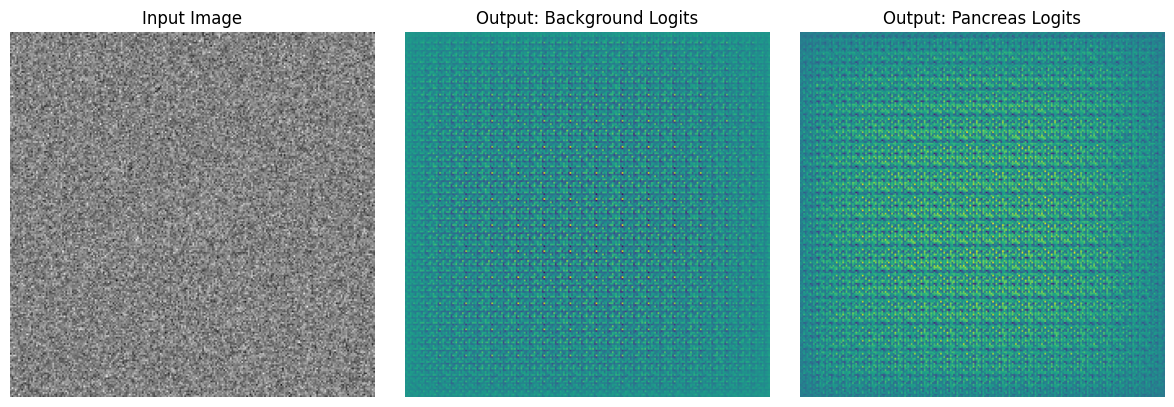

In [12]:
# Visualize a sample output
print("\nVisualizing sample output...")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Input
axes[0].imshow(x[0, 0].numpy(), cmap="gray")
axes[0].set_title("Input Image")
axes[0].axis("off")

# Output class 0 (background)
axes[1].imshow(output[0, 0].detach().numpy(), cmap="viridis")
axes[1].set_title("Output: Background Logits")
axes[1].axis("off")

# Output class 1 (pancreas)
axes[2].imshow(output[0, 1].detach().numpy(), cmap="viridis")
axes[2].set_title("Output: Pancreas Logits")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## 8. Load Model from Source Module

In [14]:
# Add parent directory to path to import src module
import sys
from pathlib import Path

parent_dir = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Import from src module
from src.model import TransUNet, create_transunet

# Create model using factory function
print("Creating model using factory function...")
print("="*60)

# Small variant (for testing)
model_small = create_transunet(
    img_size=224,
    in_channels=1,
    out_channels=2,
    variant="small",
)

print(f"\nSmall variant parameters: {sum(p.numel() for p in model_small.parameters()):,}")

# Base variant (default)
model_base = create_transunet(
    img_size=224,
    in_channels=1,
    out_channels=2,
    variant="base",
)

print(f"Base variant parameters: {sum(p.numel() for p in model_base.parameters()):,}")

Creating model using factory function...

Small variant parameters: 16,960,130
Base variant parameters: 110,243,586
Base variant parameters: 110,243,586


In [15]:
# Verify model works with actual data shape
print("\nFinal verification with base model...")
print("="*60)

x = torch.randn(1, 1, 224, 224)
model_base.eval()

with torch.no_grad():
    y = model_base(x)

print(f"Input:  {x.shape}")
print(f"Output: {y.shape}")
print(f"\nModel ready for training!")


Final verification with base model...
Input:  torch.Size([1, 1, 224, 224])
Output: torch.Size([1, 2, 224, 224])

Model ready for training!


## Summary

This notebook implemented and verified the TransUNet architecture:

1. **Transformer Components**:
   - Multi-Head Self-Attention with stored attention weights
   - MLP block with GELU activation
   - Transformer block with pre-norm residual connections

2. **CNN Encoder**:
   - ResNet-style backbone with residual blocks
   - Multi-scale feature extraction (1/4, 1/8, 1/16, 1/32)
   - Skip connections for decoder

3. **Vision Transformer Bottleneck**:
   - Processes CNN features with self-attention
   - Learnable positional embeddings
   - Captures global context

4. **CNN Decoder**:
   - U-Net style upsampling with transposed convolutions
   - Skip connections from encoder
   - Progressive resolution recovery

5. **Model Verification**:
   - Input: (B, 1, 224, 224)
   - Output: (B, 2, 224, 224)
   - Parameters: ~105M (base variant)

Next: Notebook 03 - Training Pipeline